In [2]:
import scipy.io as sio
GOOGLE_COLAB = True
if GOOGLE_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/FaceMaskDataset/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import cv2
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


np.random.seed(1000)

%matplotlib inline

In [4]:
DATA_DIR = data_path
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
VALID_DATA_DIR = os.path.join(DATA_DIR, 'validation')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

In [5]:
IMG_SIZE = 224
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)

['without_mask', 'with_mask']


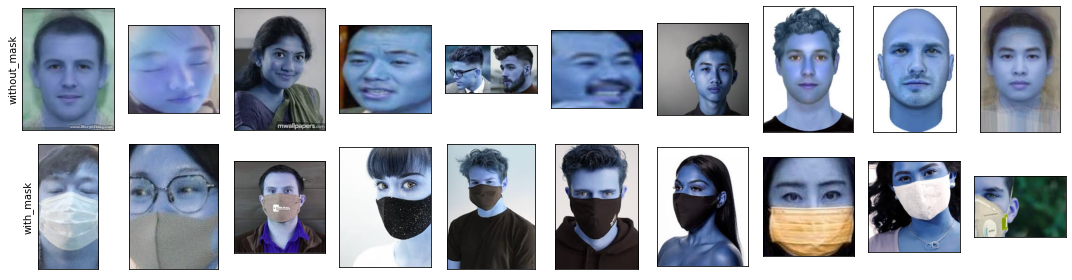

In [6]:
plt.figure(figsize=(15,4))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(2,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show() 

In [7]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
            training_data.append([img_resized, class_num]) 
        except WException as e:
            pass
        
print(len(training_data))

100%|██████████| 2732/2732 [00:19<00:00, 140.03it/s]

5516


In [8]:
valid_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            valid_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(valid_data))

100%|██████████| 570/570 [00:09<00:00, 60.39it/s]

1275


In [9]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(test_data))

100%|██████████| 423/423 [00:06<00:00, 68.07it/s] 

762


In [10]:
random.shuffle(training_data)
random.shuffle(valid_data)
random.shuffle(test_data)

In [11]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (5516, 224, 224, 3) Y_train= (5516,)


In [12]:
X_valid = []
Y_valid = []

for img, label in valid_data:
    X_valid.append(img)
    Y_valid.append(label)
    
X_valid = np.array(X_valid).astype('float32').reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_valid = np.array(Y_valid)

print(f"X_valid= {X_valid.shape} Y_valid= {Y_valid.shape}")

X_valid= (1275, 224, 224, 3) Y_valid= (1275,)


In [13]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (762, 224, 224, 3) Y_test= (762,)


In [14]:
np.random.seed(1000)

%matplotlib inline

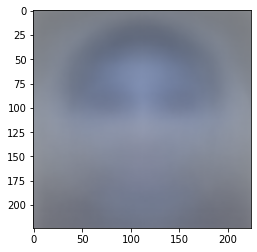

In [15]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))


In [16]:
X_train_norm, X_valid_norm, X_test_norm = X_train-mean_img, X_valid-mean_img, X_test-mean_img

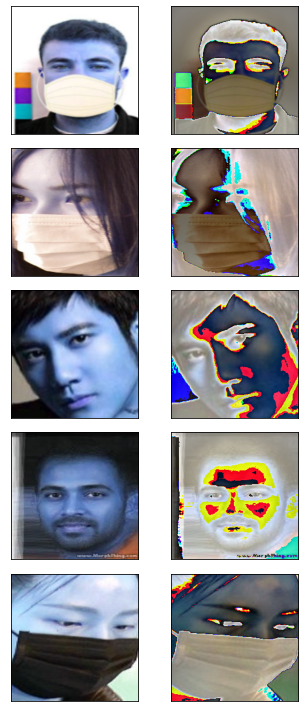

In [17]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [18]:
#Specify model parameters
tf.compat.v1.disable_eager_execution()
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train.shape[1:]),
    
    
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(2),
    layers.Activation('softmax')
])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                  

In [19]:
#Compile the model
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [20]:
#Fit the model for validation
h = model.fit(x=X_train_norm, y=Y_train, epochs=10, validation_data=(X_valid_norm, Y_valid), batch_size=32)

Train on 5516 samples, validate on 1275 samples
Epoch 1/10
5516/5516 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.8515

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5516/5516 [==============================] - 828s 150ms/sample - loss: 0.5831 - accuracy: 0.8515 - val_loss: 0.8556 - val_accuracy: 0.8549
Epoch 2/10
5516/5516 [==============================] - 835s 151ms/sample - loss: 0.2902 - accuracy: 0.8958 - val_loss: 0.3416 - val_accuracy: 0.8894
Epoch 3/10
5516/5516 [==============================] - 849s 154ms/sample - loss: 0.2768 - accuracy: 0.9039 - val_loss: 0.3908 - val_accuracy: 0.8533
Epoch 4/10
5516/5516 [==============================] - 845s 153ms/sample - loss: 0.2458 - accuracy: 0.9130 - val_loss: 0.3391 - val_accuracy: 0.8667
Epoch 5/10
5516/5516 [==============================] - 852s 154ms/sample - loss: 0.2113 - accuracy: 0.9259 - val_loss: 0.2471 - val_accuracy: 0.9106
Epoch 6/10
5516/5516 [==============================] - 842s 153ms/sample - loss: 0.1947 - accuracy: 0.9273 - val_loss: 0.2838 - val_accuracy: 0.8894
Epoch 7/10
5516/5516 [==============================] - 838s 152ms/sample - loss: 0.1943 - accuracy: 0.9304 - v

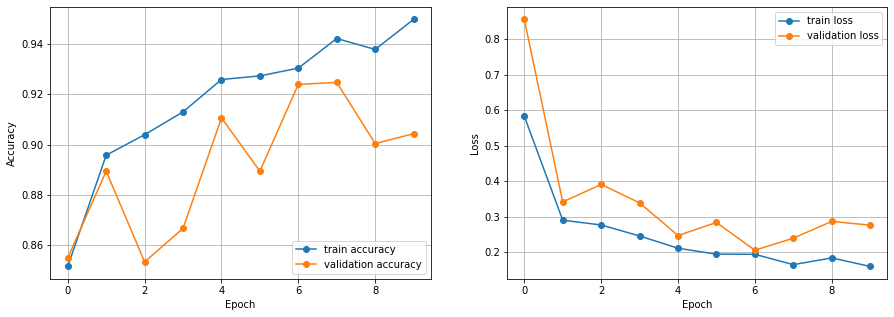

In [21]:
#Plot train accuracy
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [22]:
#Check test data accuracy
test_loss, test_acc = model.evaluate(X_test_norm, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)


Test Accuracy: 0.86745405

Test Loss: 0.3665819222845743


In [ ]:
model.save('/content/drive/My Drive/FaceMaskDataset/mask_detector.model')